## Реализация алгоритма DDPG для среды MountainCarContinuous c непрерывным действием

In [1]:
#assert python version >=3,5
import sys
assert sys.version_info >= (3,5)

import gymnasium as gym
assert gym.__version__ >= '0.27.1'

from collections import deque, namedtuple
import copy
import math
import numpy as np
from PIL import Image
from IPython import display
import matplotlib.pyplot as plt
import pdb
import random
import sklearn
import sklearn.preprocessing
from tqdm import tqdm

try:
    import Box2D
except ImportError:
    warnings.warn('Failed to import', ImportWarning)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

In [4]:
class ReplayBuffer:
    '''
        Буфер для накопления хода игры
    '''
    
    def __init__(self, size=1000000):
        '''
        size (int): размер буфера
        '''
        self.buffer = deque(maxlen=size)
        
        
    def len(self):
        '''
        длина буфера
        '''
        return len(self.buffer)
        
        
    def reset(self):
        '''
        очистка буфера
        '''
        self.buffer.clear()

        
    def remember(self, s_t:torch.Tensor, a_t:torch.Tensor, r_t:torch.Tensor, s_t_next:torch.Tensor, d:torch.Tensor):
        '''
        сохранение элемента в буфер
        '''
        self.buffer.append(Transition(s_t, a_t, s_t_next, r_t, d))

        
    def sample(self, batch_size):
        '''
        случайное семплирование из буфера размером batch_size
        '''
        size = min(batch_size, len(self.buffer))
        return random.sample(self.buffer, size)

In [5]:
class QNetworkArchitecture(nn.Module):
    '''
    Сеть для прогнозирования Q значений
    '''
    
    def __init__(self, states_dim:int, actions_dim:int):
        super(QNetworkArchitecture, self).__init__()
        '''
        states_dim - размерность состояния
        actions_dim - размерность действия
        '''
        assert(states_dim >= 1)
        assert(actions_dim >= 1)
        self.fc_state = nn.Linear(states_dim, 32)
        self.fc_action = nn.Linear(actions_dim, 32)
        self.fc = nn.Linear(64, 128)
        self.fc_value = nn.Linear(128, 1, bias=False)
        nn.init.xavier_normal_(self.fc_state.weight)
        nn.init.xavier_normal_(self.fc_action.weight)
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.xavier_normal_(self.fc_value.weight)

    def forward(self, state, action):
        out_s = F.elu(self.fc_state(state))
        out_a = F.elu(self.fc_action(action))
        out = torch.cat([out_s, out_a], dim=1)
        out = F.elu(self.fc(out))
        out = self.fc_value(out)
        return out

In [6]:
class PolicyNetworkArchitecture(nn.Module):
    '''
    Cеть политики для прогнозирования действий исходя из состояний
    '''
    
    def __init__(self, input_dim:int, out_dim:int):
        '''
        input_dim - размерность состояния
        out_dim - размерность действия
        '''
        super(PolicyNetworkArchitecture, self).__init__()
        assert(input_dim >= 1)
        assert(out_dim >= 1)
        self.fc_1 = nn.Linear(input_dim, 64)
        self.fc_2 = nn.Linear(64, 32)
        self.fc_out = nn.Linear(32, out_dim, bias=False)
        nn.init.xavier_normal_(self.fc_1.weight)
        nn.init.xavier_normal_(self.fc_2.weight)
        nn.init.xavier_normal_(self.fc_out.weight)

    def forward(self, x):
        out = F.elu(self.fc_1(x))
        out = F.elu(self.fc_2(out))
        out = torch.tanh(self.fc_out(out))
        return out


In [7]:
class OrnsteinUhlenbeckActionNoise:
    '''
    Ornstein-Uhlenbeck noise implemented by OpenAI
    Copied from https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py
    '''
    def __init__(self, mu:float, sigma:float, theta:float=.15, dt:float=1e-2, x0:float=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

In [8]:
class DDPGAgent():
    '''
    Класс DDPGAgent - реализация алгоритма DDPG
    '''
    
    def __init__(self, env:gym.Env, reply_buffer:ReplayBuffer, q_net:nn.Module=None, policy_net:nn.Module=None, device:torch.cuda.device=None, 
                 lr:float=1e-4, gamma:float=0.99, tau:float=0.005, batch_size:int=250, explore_episodes_percent:float = 0.75):
        '''
        Parameters:
        env - разыгрываемая среда
        reply_buffer - буффер для накопления статистики игры (состояний, действий, наград и тд)
        q_net - сеть-критик для прогноза q значений
        policy_net - сеть-эктор для прогноза политики
        device - устройство 
        lr - лернинг рейты для критика и эктора
        gamma - коэффициент дисконта
        tau - коэффициент обновления таргет сетей
        batch_size - размерт семплирования батча из буфера игры
        explore_episodes_percent - процент эпизодов в которых агент будет выполнять exploration среды
        '''
        assert(env is not None)
        self._env = env
        self.a_low = torch.tensor(env.action_space.low, device=device)
        self.a_high = torch.tensor(env.action_space.high, device=device)
        assert(reply_buffer is not None)
        self._reply_buffer = reply_buffer
        self._reply_buffer.reset()
        assert(q_net is not None)
        self._q_net = q_net
        self._target_q_net = copy.deepcopy(q_net)
        assert(policy_net is not None)
        self._policy_net = policy_net
        self._target_policy_net = copy.deepcopy(policy_net)
        assert(tau > 0. and tau < 1.)
        self._tau = tau
        assert(device is not None)        
        self._device = device
        assert(lr > 0 and lr < 1)
        assert(gamma > 0.9 and gamma < 1)
        self._gamma = gamma
        assert(tau > 0)
        self._tau = tau
        assert(batch_size > 0)
        self._batch_size = batch_size
        assert(explore_episodes_percent > 0 and explore_episodes_percent < 1)
        self._explore_episodes_percent = explore_episodes_percent
        self._total_rewards = []

        self._policy_net.to(device)
        self._target_policy_net.to(device)
        self._q_net.to(device)
        self._target_q_net.to(device)
        
        self._q_optimizer = optim.AdamW(self._q_net.parameters(), lr=lr,  amsgrad=True)
        self._p_optimizer = optim.AdamW(self._policy_net.parameters(), lr=lr,  amsgrad=True)
        
        self._noise_gen = OrnsteinUhlenbeckActionNoise(mu=np.zeros(env.action_space.shape[0]), sigma=np.ones(env.action_space.shape[0]), theta=0.15, dt=1)
        self._scaler = self._fit_scaler(env)
        

    def learn(self, num_episodes:int) -> None:
        '''
            Выполнить обучение за num_episodes эпизодов
        '''
        for i_episode in range(num_episodes):
            episode_reward = 0
            state, _ = self._env.reset()
            state = self._scaler.transform([state])[0]
            done = False
            step = 0
            episodes_to_explore = int(num_episodes * self._explore_episodes_percent)
            while not done:
                action = self.act(state)[0]
                if i_episode < episodes_to_explore:
                    p = i_episode / episodes_to_explore
                    action = action * p + (1 - p) * self._noise_gen()
                    action = np.clip(action, self._env.action_space.low, self._env.action_space.high)
                #step the game
                next_state, reward, terminated, truncated, _ = self._env.step(action)
                done = terminated or truncated
                episode_reward += reward
                next_state = self._scaler.transform([next_state])[0]
               
                self._reply_buffer.remember(
                    torch.tensor(state, dtype=torch.float, device=self._device), 
                    torch.tensor(action, dtype=torch.float, device=self._device), 
                    torch.tensor([reward], dtype=torch.float, device=self._device),
                    torch.tensor(next_state, dtype=torch.float, device=self._device), 
                    torch.tensor([done], dtype=torch.int8, device=self._device)
                )            
                state = next_state
                
                if self._reply_buffer.len() > self._batch_size * 3:
                    self._update_networks()
                    self._synchronize()
            #end of episode
            self._total_rewards.append(episode_reward)
            print(f'{i_episode}:{episode_reward}:{np.mean(self._total_rewards[-50:])}\r', end='')
                
    def act(self, state:np.ndarray) -> np.ndarray:
        '''
        Выбрать действие исходя из текущей политики для состояний state
        '''
        state = np.expand_dims(state, axis=0)
        state = torch.as_tensor(state, dtype=torch.float).to(self._device)
        with torch.inference_mode():
            a_t = self._policy_net(state)
            a_t = a_t.cpu().numpy()
            return np.clip(a_t, env.action_space.low, env.action_space.high)
    
    def total_rewards(self):
        '''
        Награды агента
        '''
        return self._total_rewards.copy()
    
    
    def _fit_scaler(self, env:gym.Env):
        '''
        Обучаем скейлер для состояний среды
        '''
        state_space_samples = np.array(
            [env.observation_space.sample() for x in range(10000)])
        scaler = sklearn.preprocessing.StandardScaler()
        scaler.fit(state_space_samples)
        return scaler    
        
    def _update_networks(self):
        '''
        Обновление сетей
        '''
        batch = self._reply_buffer.sample(self._batch_size)
        batch = Transition(*zip(*batch))
        states = torch.stack(batch.state, dim=0)
        actions = torch.stack(batch.action, dim=0)
        rewards = torch.stack(batch.reward, dim=0)
        dones = torch.stack(batch.done, dim=0)
        next_states = torch.stack(batch.next_state, dim=0)
        
        with torch.inference_mode():
            target_actions = self._target_policy_net(next_states)
            #target_actions_c = torch.clamp(target_actions, self.a_low, self.a_high)
            target_q = self._target_q_net(next_states, target_actions)
        target_q = rewards + self._gamma * (1 - dones) * target_q.detach()
        q = self._q_net(states, actions)
        self._q_optimizer.zero_grad()
        q_loss = F.smooth_l1_loss(q, target_q)
        #nn.utils.clip_grad_value_(self._q_net.parameters(), 100.)
        q_loss.backward()
        self._q_optimizer.step()
        
        mu = self._policy_net(states)
        #mu_c = torch.clamp(mu, self.a_low, self.a_high)
        self._set_req_grads(self._q_net, False)
        q_optim = self._q_net(states, mu)
        p_loss = -q_optim.mean()
        self._p_optimizer.zero_grad()
        p_loss.backward()
        #nn.utils.clip_grad_value_(self._policy_net.parameters(), 100.)
        self._p_optimizer.step()
        self._set_req_grads(self._q_net, True)

    def _set_req_grads(self, net:nn.Module, req_grad_flag:bool):
        for p in net.parameters():
            p.requires_grad = req_grad_flag
            
    def _synchronize(self):
        '''
            синхронизация весов target сетей с оригинальными сетями
        '''
        for origin, target in zip([self._q_net, self._policy_net],[self._target_q_net, self._target_policy_net]):
            origin_state_dict = origin.state_dict()
            target_state_dict = target.state_dict()
            for key in origin_state_dict:
                target_state_dict[key] = origin_state_dict[key]*self._tau + target_state_dict[key]*(1-self._tau)
            target.load_state_dict(target_state_dict)
                    

In [9]:
#создаем среду
env = gym.make('MountainCarContinuous-v0', render_mode="rgb_array")

In [10]:
p_network = PolicyNetworkArchitecture(env.observation_space.shape[0], env.action_space.shape[0])
q_network = QNetworkArchitecture(env.observation_space.shape[0], env.action_space.shape[0])
reply_buffer=ReplayBuffer(size=20000)
agent = DDPGAgent(env, reply_buffer, q_network, p_network, device, batch_size=64)

In [11]:
agent.learn(num_episodes=200)

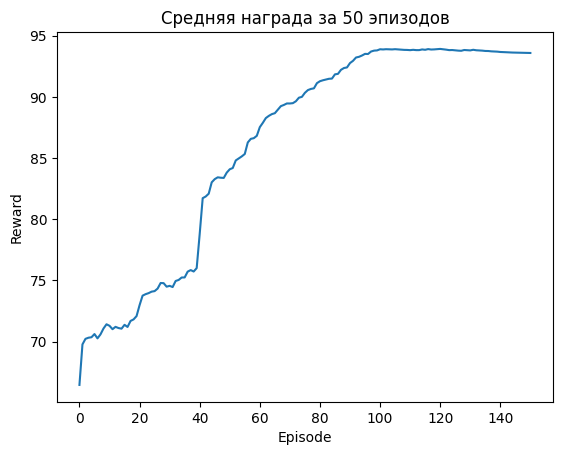

In [12]:
window_size = 50
moving_avg = np.convolve(agent.total_rewards(), np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_avg)
plt.title('Средняя награда за 50 эпизодов')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

#### Розыгрыш игры

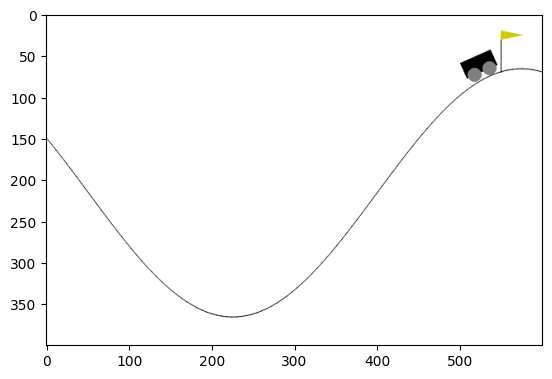

In [13]:
state, info = env.reset(seed=1233)
#розыгрыш игры
for i in range(env.spec.max_episode_steps):
    if i % 2 == 0:
        plt.imshow(env.render())
        display.display(plt.gcf())    
        display.clear_output(wait=True)
    action = agent.act(agent._scaler.transform([state])[0])
    state, reward, terminated, truncated, info = env.step(action[0])
    if terminated or truncated:
        break